In [1]:
# Packages
# Data Processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
import seaborn as sns
import math
from scipy import stats
from scipy.stats import norm
import os
for dirname, _, filenames in os.walk('/price_data.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# version check
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")

numpy version: 1.26.3
pandas version: 2.2.0


In [3]:
# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

In [4]:
# setting
path_root = "/kaggle/input/"
seed = 394

In [5]:
# pandas display setting
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 200)

In [6]:
df_clothes = pd.read_csv(path_root + "clothes-price-prediction/clothes_price_prediction_data.csv")

# 1. Overview

In [7]:
df_clothes.shape

(1000, 6)

In [8]:
display(df_clothes.head())
display(df_clothes.tail())

,Brand,Category,Color,Size,Material,Price
0,New Balance,Dress,White,XS,Nylon,182
1,New Balance,Jeans,Black,XS,Silk,57
2,Under Armour,Dress,Red,M,Wool,127
3,Nike,Shoes,Green,M,Cotton,77
4,Adidas,Sweater,White,M,Nylon,113


,Brand,Category,Color,Size,Material,Price
995,Puma,Jeans,Black,L,Polyester,176
996,Puma,Jacket,Red,XXL,Silk,110
997,Reebok,Sweater,Blue,XS,Denim,127
998,Under Armour,Sweater,Black,XXL,Denim,69
999,New Balance,Jacket,Yellow,XS,Wool,174


In [9]:
df_clothes.columns

Index(['Brand', 'Category', 'Color', 'Size', 'Material', 'Price'], dtype='object')

In [10]:
df_clothes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Brand     1000 non-null   object
 1   Category  1000 non-null   object
 2   Color     1000 non-null   object
 3   Size      1000 non-null   object
 4   Material  1000 non-null   object
 5   Price     1000 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 47.0+ KB


In [11]:
# categorical features
list_categorical_features = [
    'Brand', 'Category', 'Color', 'Size', 'Material'
]
df_clothes[list_categorical_features] = df_clothes[list_categorical_features].astype('category')
df_clothes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Brand     1000 non-null   category
 1   Category  1000 non-null   category
 2   Color     1000 non-null   category
 3   Size      1000 non-null   category
 4   Material  1000 non-null   category
 5   Price     1000 non-null   int64   
dtypes: category(5), int64(1)
memory usage: 13.9 KB


In [12]:
# descriptive statistics
display(df_clothes.describe().round(3).T) # numerical
display(df_clothes.describe(include = ['object', 'bool', 'category']).T) # categorical

,count,mean,std,min,25%,50%,75%,max
Price,1000.0,106.289,53.695,10.0,59.75,108.0,150.0,199.0


,count,unique,top,freq
Brand,1000,6,Under Armour,179
Category,1000,6,Jacket,191
Color,1000,6,Yellow,173
Size,1000,6,XS,196
Material,1000,6,Polyester,175


# 2. Data Cleaning

In [13]:
# subsetting
df_clothes = df_clothes[[
    'Brand', 'Category', 'Color', 'Size', 'Material', 'Price'
]].copy()

In [14]:
# missing values
df_clothes.isnull().sum()

Brand       0
Category    0
Color       0
Size        0
Material    0
Price       0
dtype: int64

In [16]:
# duplicated rows
df_clothes.loc[df_clothes.duplicated()]

,Brand,Category,Color,Size,Material,Price


There is no missing row or duplicated row.

# 3. Univariate Analysis

In [17]:
def summary_numerical_dist(df_data, col, q_min, q_max):
    
    fig = plt.figure(figsize = (8, 4), facecolor = "white")

    layout_plot = (2, 2)
    num_subplot = 4
    axes = [None for _ in range(num_subplot)]
    list_shape_subplot = [[(0, 0), (0, 1), (1, 0), (1, 1)], [1, 1, 1, 1], [1, 1, 1, 1]]
    for i in range(num_subplot):
        axes[i] = plt.subplot2grid(
            layout_plot, list_shape_subplot[0][i],
            rowspan = list_shape_subplot[1][i],
            colspan = list_shape_subplot[2][i]
        )

    sns.histplot(data = df_data, x = col, kde = True, ax = axes[0])
    stats.probplot(x = df_data[col], dist = stats.norm, plot = axes[1])
    sns.boxplot(data = df_data, x = col, ax = axes[2])
    pts = df_data[col].quantile(q = np.arange(q_min, q_max, 0.01))
    sns.lineplot(x = pts.index, y = pts, ax = axes[3])
    axes[3].grid(True)

    list_title = ["Histogram", "QQ plot", "Boxplot", "Outlier"]
    for i in range(num_subplot):
        axes[i].set_title(list_title[i])
    plt.suptitle(f"Distribution of: {col}", fontsize = 15)
    plt.tight_layout()
    plt.show()

In [18]:
def summary_categorical_dist(df_data, col):
    
    fig = plt.figure(figsize = (8, 4), facecolor = "white")

    layout_plot = (1, 2)
    num_subplot = 2
    axes = [None for _ in range(num_subplot)]
    list_shape_subplot = [[(0, 0), (0, 1)], [1, 1], [1, 1]]
    for i in range(num_subplot):
        axes[i] = plt.subplot2grid(
            layout_plot, list_shape_subplot[0][i],
            rowspan = list_shape_subplot[1][i],
            colspan = list_shape_subplot[2][i]
        )
    
    count = df_data[col].value_counts().sort_index()
    
    sns.countplot(data = df_data, y = col, order = count.index, ax = axes[0])
    axes[1].pie(data = df_data, x = count, labels = count.index, autopct = '%1.1f%%', startangle = 90)
    
    list_title = ["Counts", "Proportions"]
    for i in range(num_subplot):
        axes[i].set_title(list_title[i])
    plt.suptitle(f"Distribution of: {col}", fontsize = 15)
    plt.tight_layout()
    plt.show()

## 3.1. Numerical

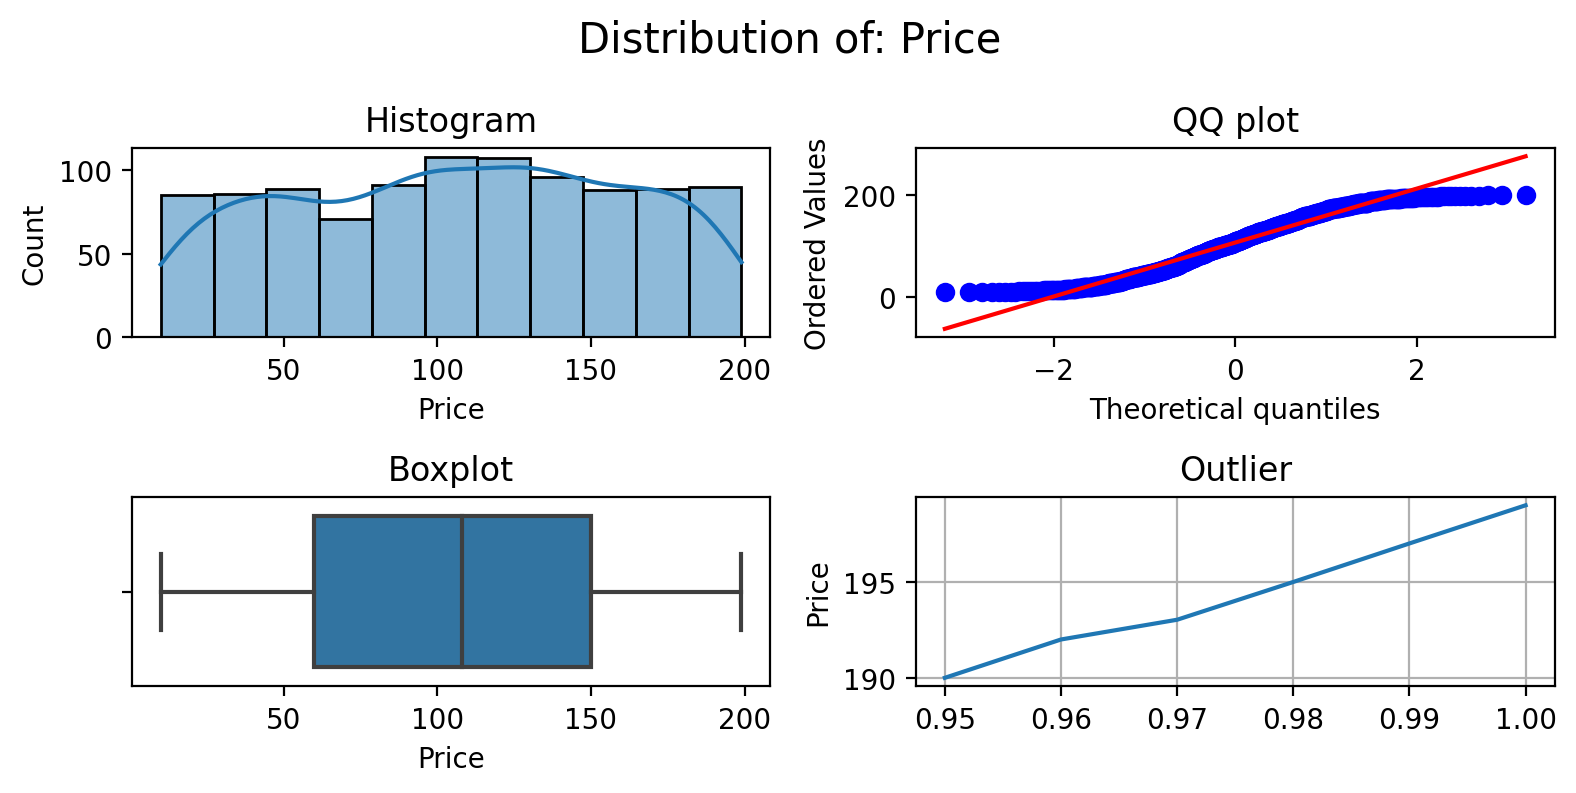

In [19]:
summary_numerical_dist(df_clothes, 'Price', .95, 1)

## 3.2. Categorical

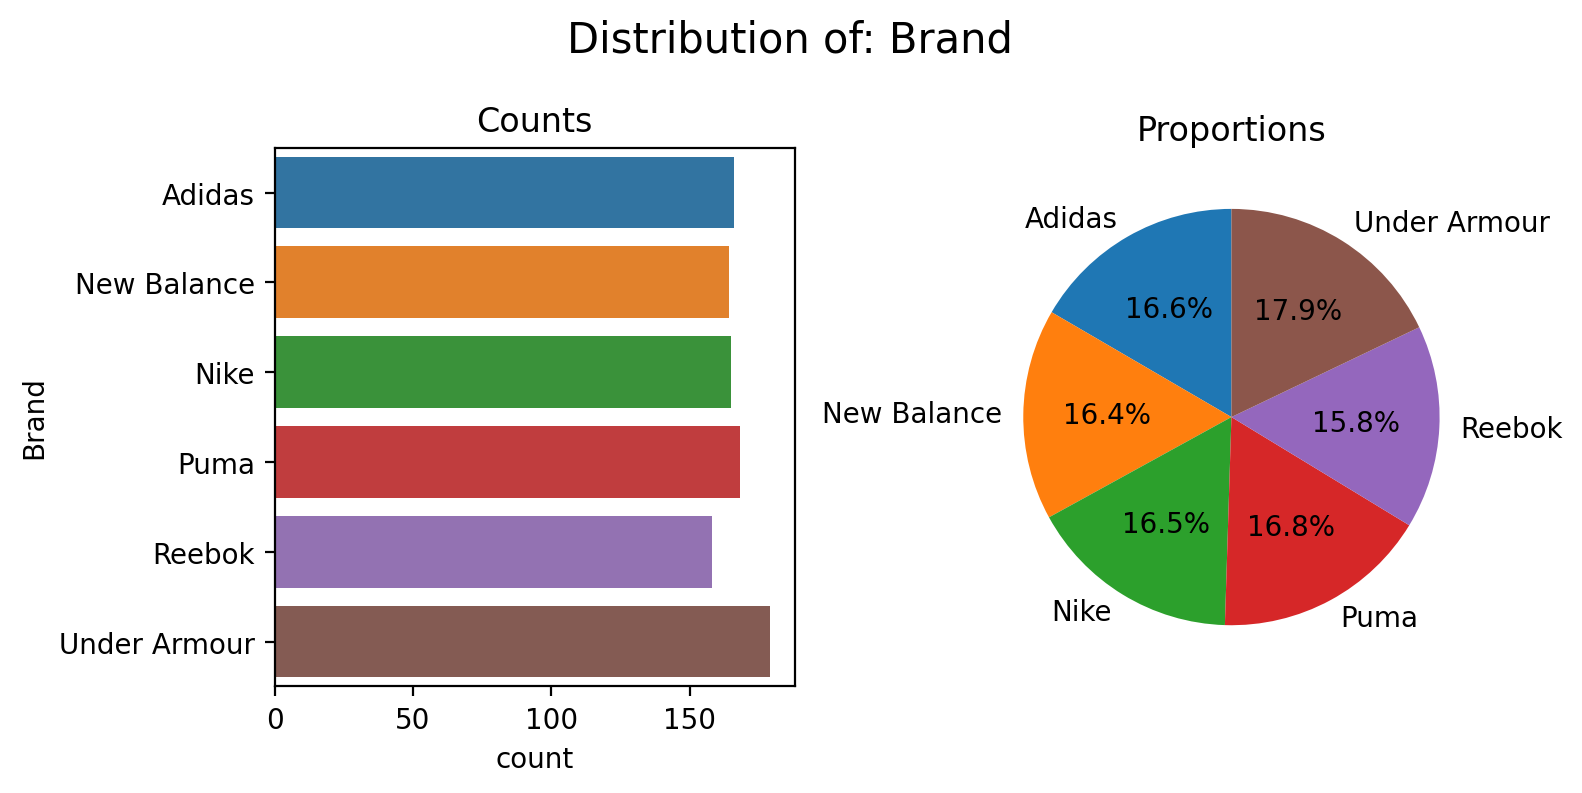

In [20]:
summary_categorical_dist(df_clothes, 'Brand')

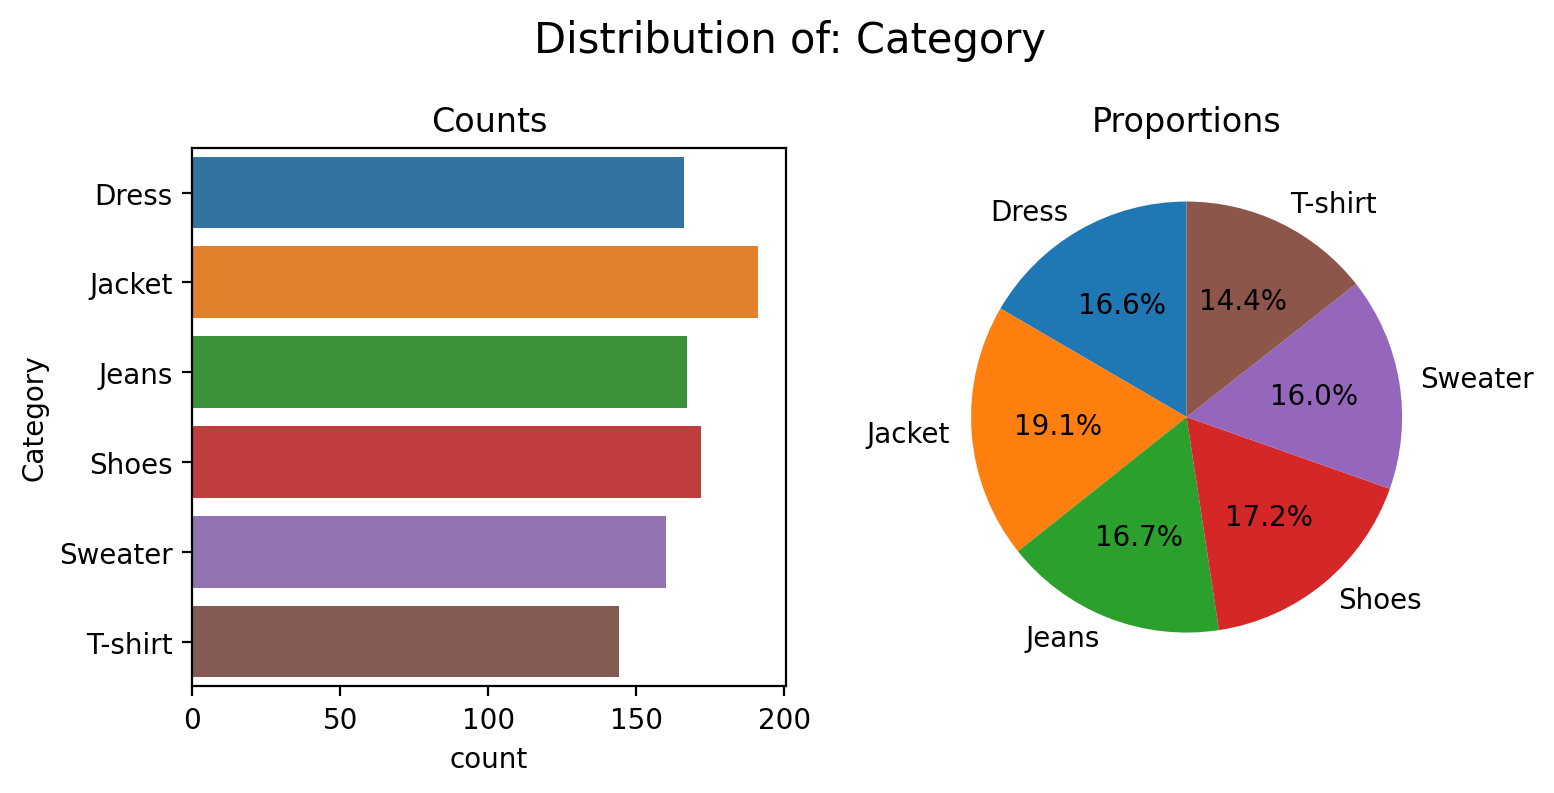

In [21]:
summary_categorical_dist(df_clothes, 'Category')

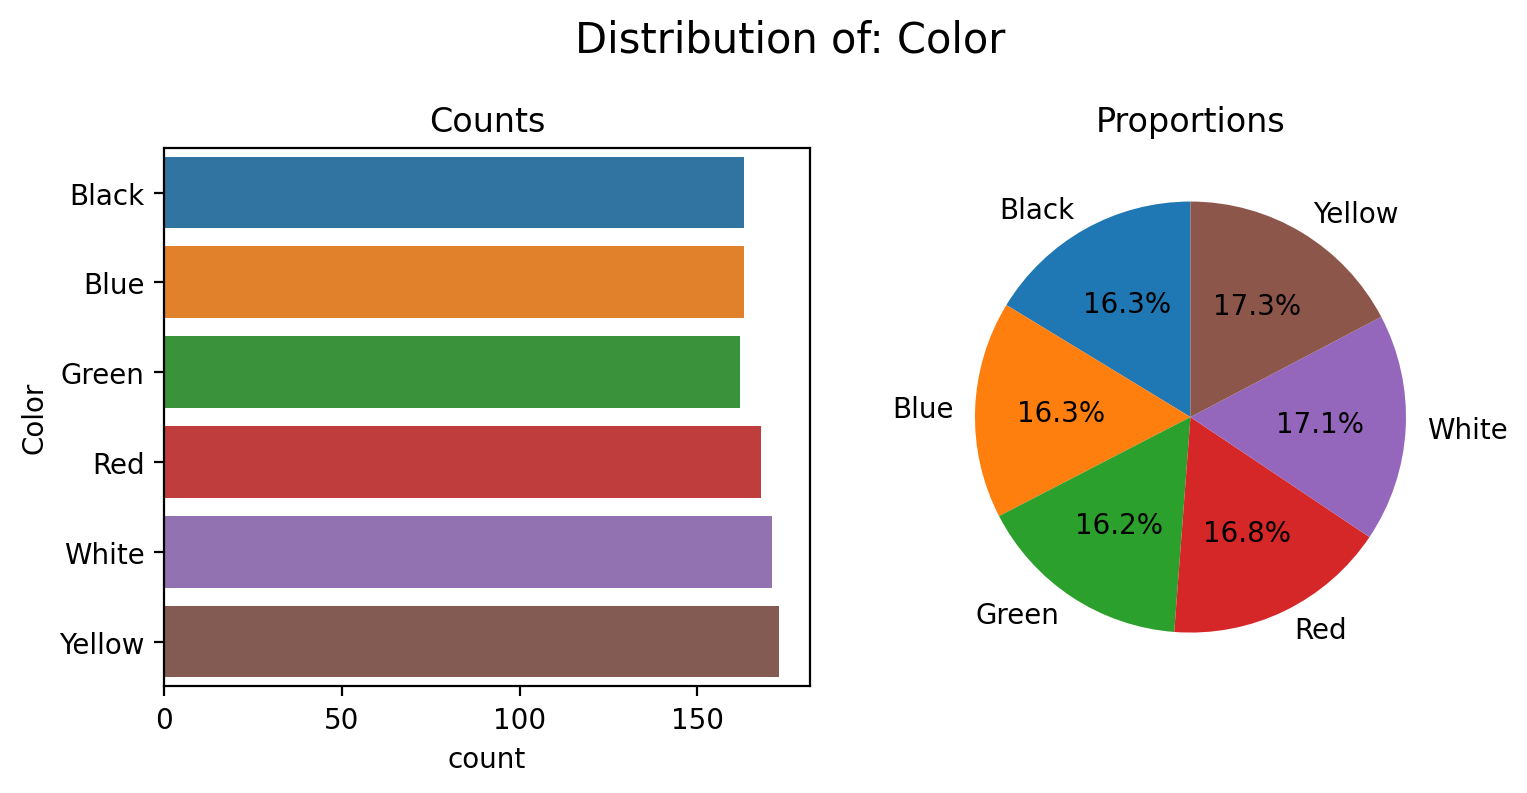

In [22]:
summary_categorical_dist(df_clothes, 'Color')

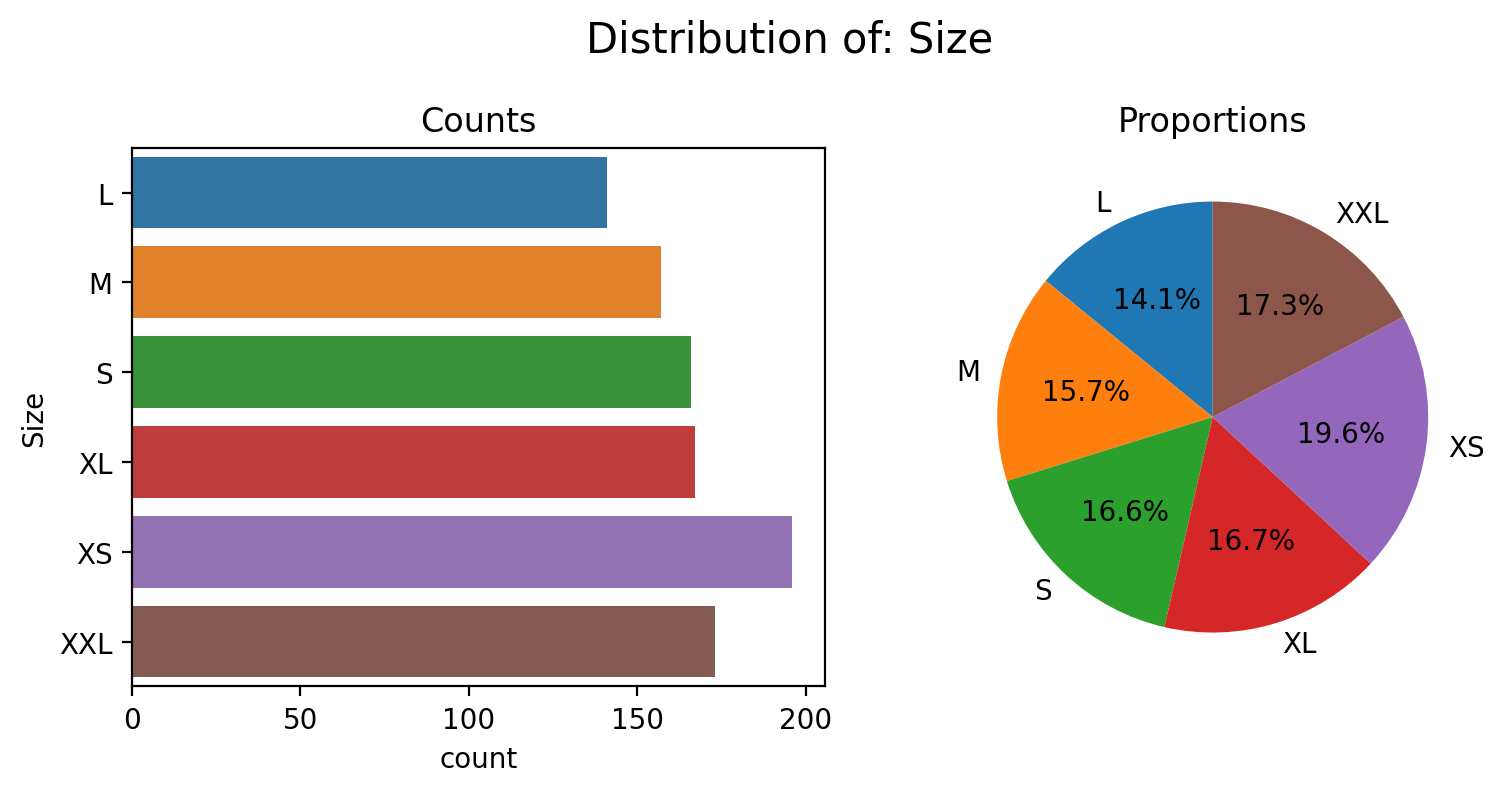

In [23]:
summary_categorical_dist(df_clothes, 'Size')

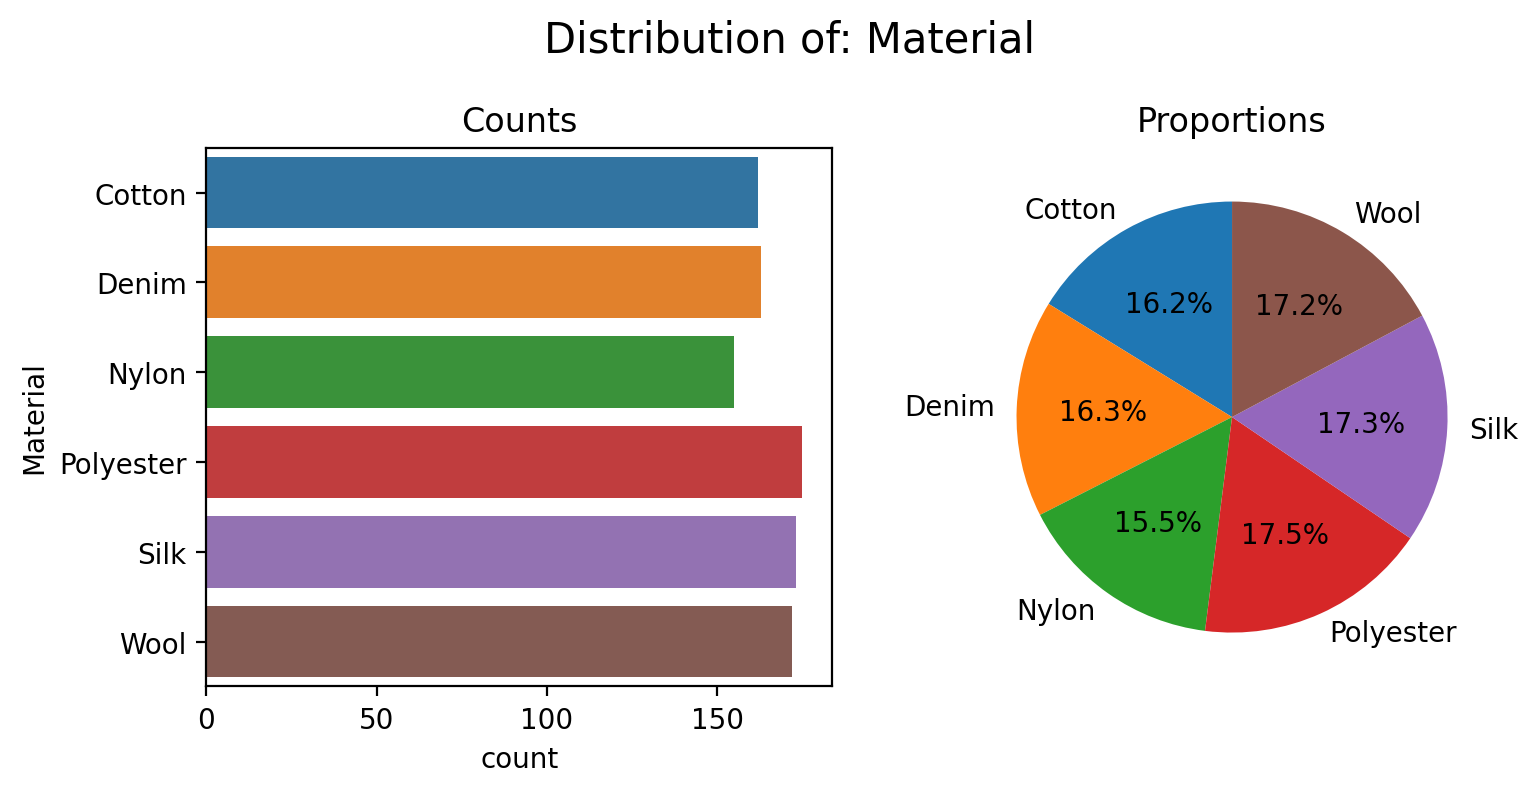

In [24]:
summary_categorical_dist(df_clothes, 'Material')

# 4. Relationship Analysis

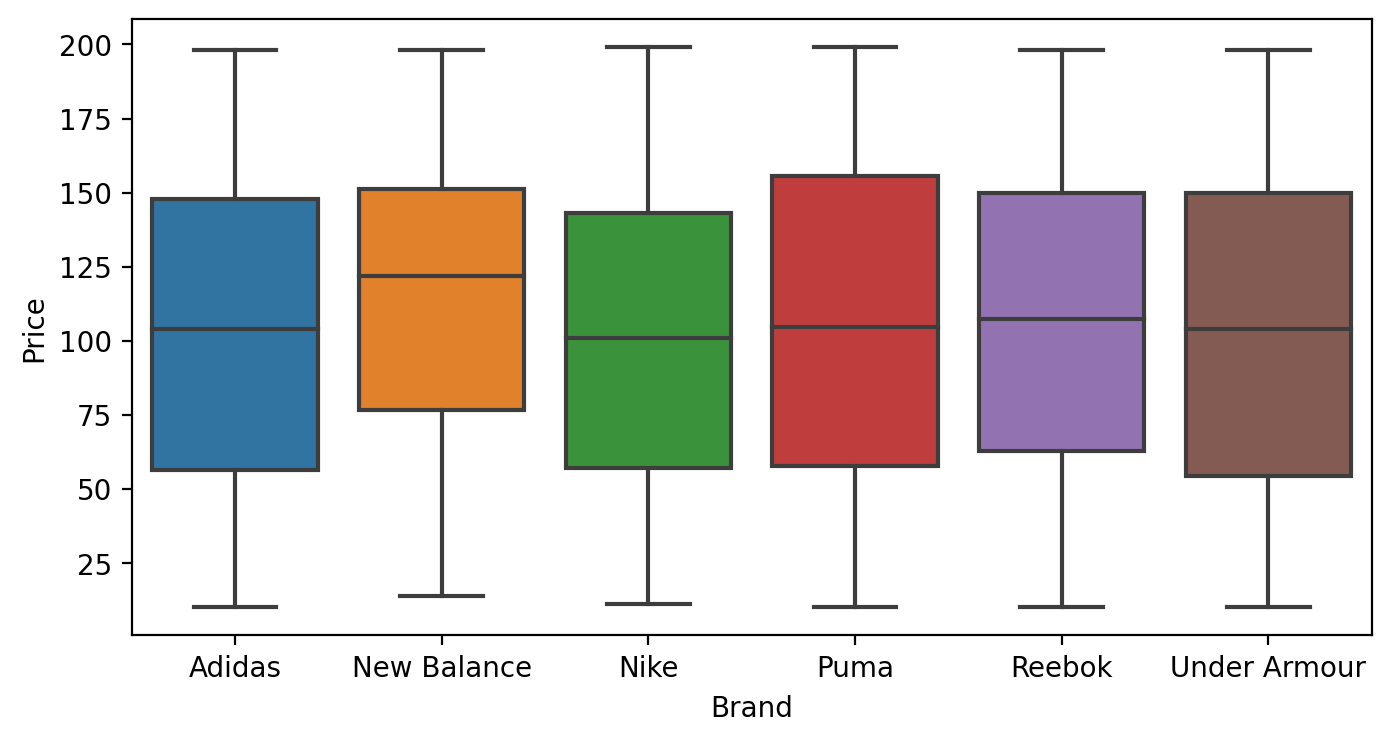

In [25]:
plt.figure(figsize = (8, 4), facecolor = "white")

sns.boxplot(
    data = df_clothes, 
    x = 'Brand', y = 'Price'
)

plt.show()

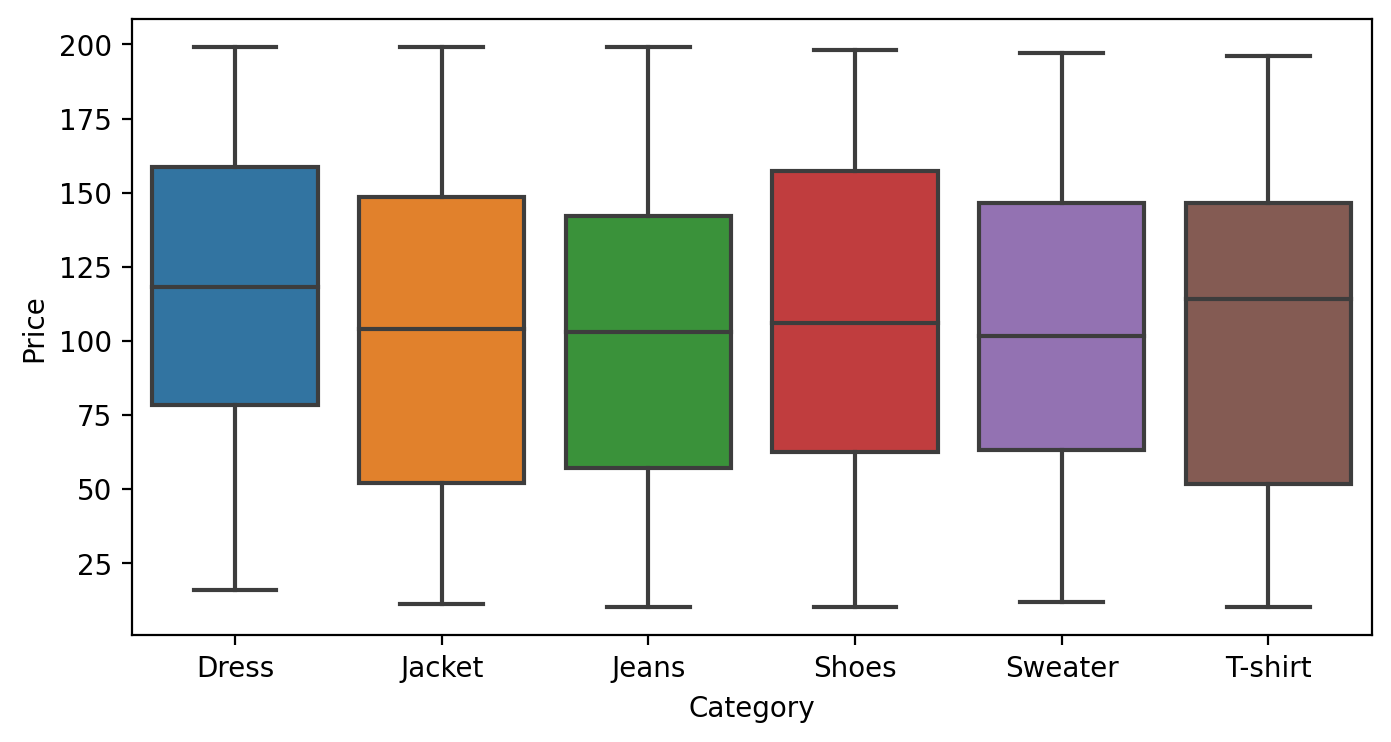

In [26]:
plt.figure(figsize = (8, 4), facecolor = "white")

sns.boxplot(
    data = df_clothes, 
    x = 'Category', y = 'Price'
)

plt.show()

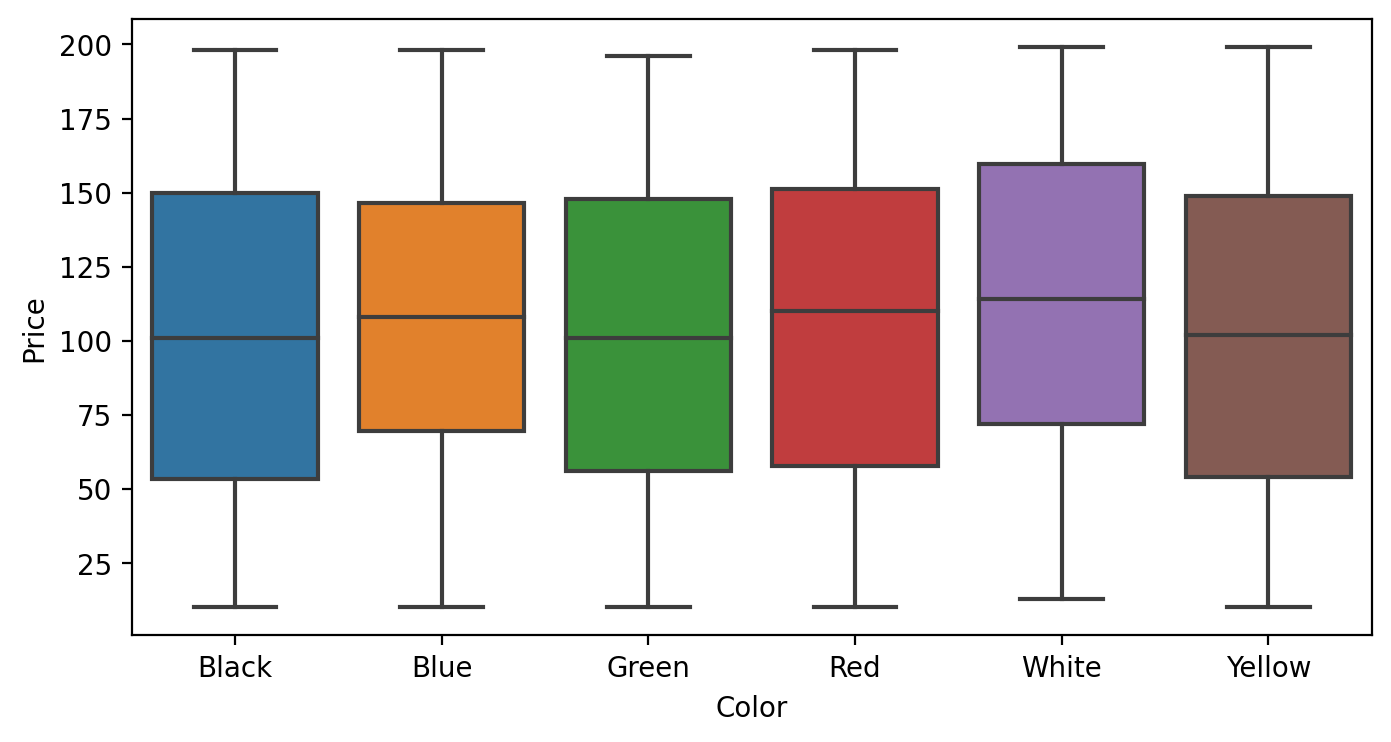

In [27]:
plt.figure(figsize = (8, 4), facecolor = "white")

sns.boxplot(
    data = df_clothes, 
    x = 'Color', y = 'Price'
)

plt.show()

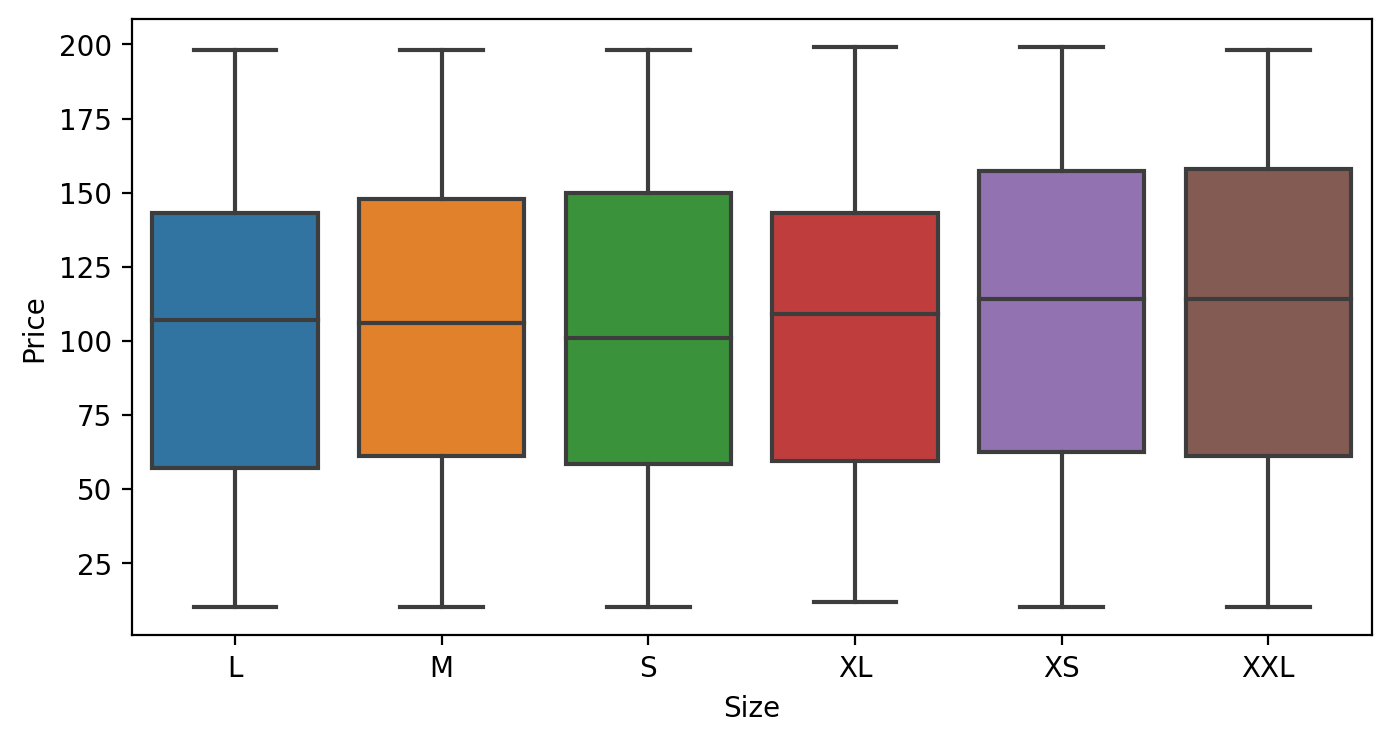

In [28]:
plt.figure(figsize = (8, 4), facecolor = "white")

sns.boxplot(
    data = df_clothes, 
    x = 'Size', y = 'Price'
)

plt.show()

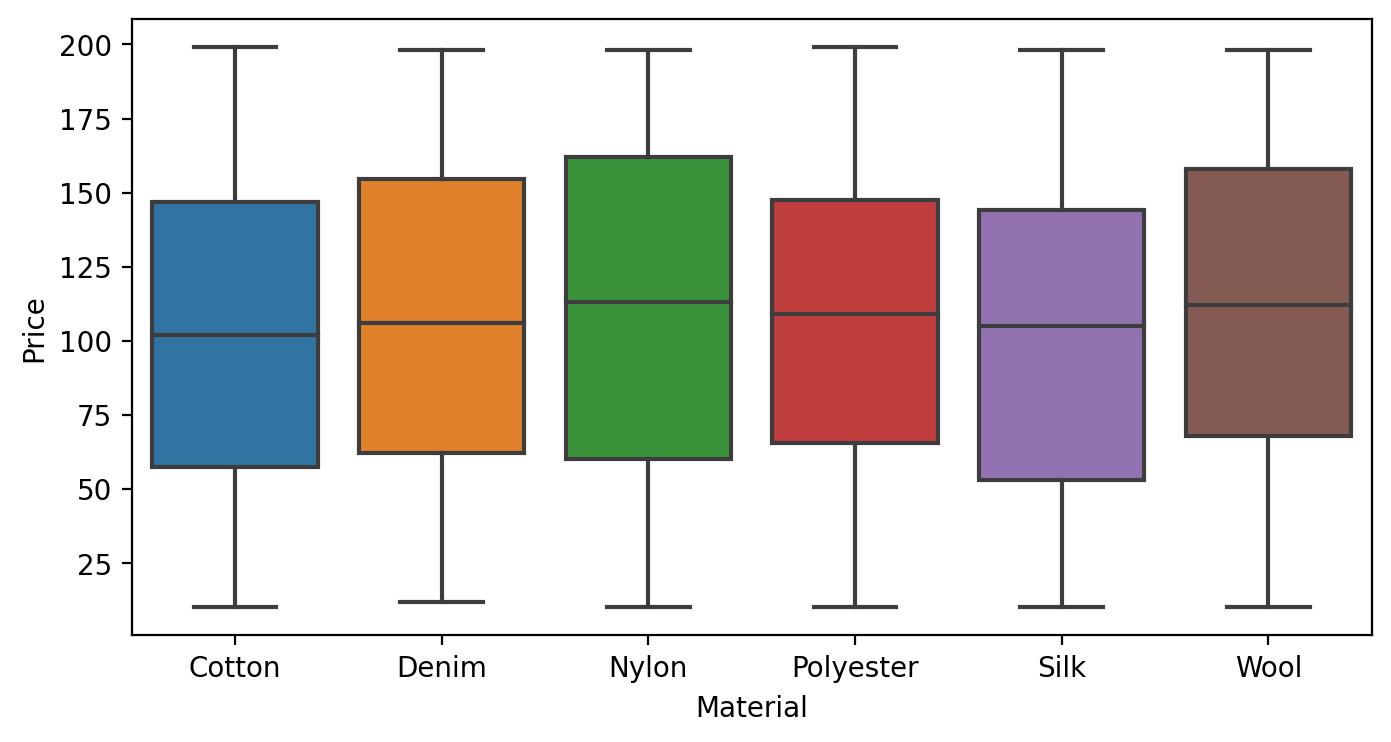

In [29]:
plt.figure(figsize = (8, 4), facecolor = "white")

sns.boxplot(
    data = df_clothes, 
    x = 'Material', y = 'Price'
)

plt.show()